<a href="https://colab.research.google.com/github/mmeierer/MLP---TensorFlow-vs-PyTorch/blob/main/mlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification using an MLP with PyTorch

## 1. Import & Processing

### a) Importing modules

In [ ]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

### b) Importing data

In [ ]:
train_data = pd.read_csv('https://github.com/mmeierer/MLP---TensorFlow-vs-PyTorch/raw/main/train.csv')
test_data = pd.read_csv('https://github.com/mmeierer/MLP---TensorFlow-vs-PyTorch/raw/main/test.csv')

In [ ]:
train_data.head()

,CustomerId,Churned,FrequentBuyerClass,Sex,Age,NrSiblingsSpouses,NrParentsChildren
0,1,0,3,male,22.0,1,0
1,2,1,1,female,38.0,1,0
2,3,1,3,female,26.0,0,0
3,4,1,1,female,35.0,1,0
4,5,0,3,male,35.0,0,0


In [ ]:
test_data.head()

,CustomerId,FrequentBuyerClass,Sex,Age,NrSiblingsSpouses,NrParentsChildren
0,892,3,male,34.5,0,0
1,893,3,female,47.0,1,0
2,894,2,male,62.0,0,0
3,895,3,male,27.0,0,0
4,896,3,female,22.0,1,1


### c) Data preparation

In [ ]:
def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix=column)], axis=1)
        data = data.drop(column, axis=1)
    return data

In [ ]:
train_data = train_data[train_data.columns[-6:]]
test_data = test_data[test_data.columns[-5:]]

In [ ]:
dummy_columns = ["FrequentBuyerClass"]
train_data=dummy_data(train_data, dummy_columns)
test_data=dummy_data(test_data, dummy_columns)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,male,22.0,1,0,0,0,1
1,1,female,38.0,1,0,1,0,0
2,1,female,26.0,0,0,0,0,1
3,1,female,35.0,1,0,1,0,0
4,0,male,35.0,0,0,0,0,1


In [ ]:
def sex_to_int(data):
    le = LabelEncoder()
    le.fit(["male","female"])
    data["Sex"]=le.transform(data["Sex"]) 
    return data

train_data = sex_to_int(train_data)
test_data = sex_to_int(test_data)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,1,22.0,1,0,0,0,1
1,1,0,38.0,1,0,1,0,0
2,1,0,26.0,0,0,0,0,1
3,1,0,35.0,1,0,1,0,0
4,0,1,35.0,0,0,0,0,1


In [ ]:
def normalize_age(data):
    scaler = MinMaxScaler()
    data["Age"] = scaler.fit_transform(data["Age"].values.reshape(-1,1))
    return data
    
train_data = normalize_age(train_data)
test_data = normalize_age(test_data)
train_data.head()

,Churned,Sex,Age,NrSiblingsSpouses,NrParentsChildren,FrequentBuyerClass_1,FrequentBuyerClass_2,FrequentBuyerClass_3
0,0,1,0.271174,1,0,0,0,1
1,1,0,0.472229,1,0,1,0,0
2,1,0,0.321438,0,0,0,0,1
3,1,0,0.434531,1,0,1,0,0
4,0,1,0.434531,0,0,0,0,1


In [ ]:
train_data.Age.fillna(train_data.Age.median(),inplace=True)
test_data.Age.fillna(test_data.Age.median(),inplace=True)

In [ ]:
def split_valid_test_data(data, fraction=(0.2)):
    y_data = data["Churned"]

    x_data = data.drop(["Churned"], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=fraction)

    return x_train.values, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_valid_test_data(train_data)
print("x_train:{}, {}".format(x_train.shape, type(x_train)))
print("y_train:{}, {}".format(y_train.shape, type(y_train)))

print("x_test:{}, {}".format(x_test.shape, type(x_test)))
print("y_test:{}, {}".format(y_test.shape, type(y_test)))

x_train:(712, 7), <class 'numpy.ndarray'>
y_train:(712,), <class 'pandas.core.series.Series'>
x_test:(179, 7), <class 'pandas.core.frame.DataFrame'>
y_test:(179,), <class 'pandas.core.series.Series'>


In [ ]:
y_train = y_train.values
x_test = x_test.values
y_test = y_test.values

## 2. Model specific data preparation

### a) Load the data

In [ ]:
x_train_pt = torch.from_numpy(x_train).type(torch.FloatTensor)
x_test_pt = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train_pt = torch.from_numpy(y_train).type(torch.FloatTensor)
y_test_pt = torch.from_numpy(y_test).type(torch.FloatTensor)

### b) Tensor view of the data

In [ ]:
x_train_pt[0]

tensor([0.0000, 0.3466, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000])

In [ ]:
y_train_pt[0]

tensor(1.)

## 3. Model definition

### a) Sequentially add layers

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)

Sequential(
  (0): Linear(in_features=7, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
model_pt = nn.Sequential(nn.Linear(x_train.shape[1], 16),
                      nn.ReLU(),
                      nn.Linear(16, 32),
                      nn.ReLU(),
                      nn.Linear(32, 1),
                      nn.Sigmoid())

In [ ]:
model_pt.apply(weights_init)

### b) Inspect the model

In [ ]:
print(model_pt)

### c) Inspect the first hidden layer

In [ ]:
model_pt[0].weight[0]

tensor([-0.2635, -0.5851,  0.4984,  0.1801,  0.2405,  0.7361, -0.3908],
       grad_fn=<SelectBackward>)

In [ ]:
model_pt[0].weight.shape

torch.Size([16, 7])

In [ ]:
model_pt[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [ ]:
model_pt[0].bias.shape

torch.Size([16])

## 4. Loss & Optimizer

In [ ]:
optimizer_pt = optim.Adam(model_pt.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn_pt = nn.BCELoss()

## 5. Training

### a) Training loop

In [ ]:
def get_correct(y_pred,labels):
  pred = y_pred > 0.5
  truth = labels > 0.5

  return pred.eq(truth.data).sum().item()

In [ ]:
def train_step_pt(model, optimizer, loss_fn, batch_size=10):
    model.train()
    train_correct = 0
    total_loss = 0.0
    for beg_i in range(0, x_train_pt.size(0), batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]
        y_train_batch_pt = y_train_pt[beg_i:beg_i + batch_size]

        optimizer.zero_grad()
        
        y_pred_pt = model(x_train_batch_pt)

        loss = loss_fn(y_pred_pt.squeeze(), y_train_batch_pt)

        loss.backward()
        
        optimizer.step()

        train_correct += get_correct(y_pred_pt.squeeze(),y_train_batch_pt)       
        total_loss += np.sum(loss.data.numpy())
    return total_loss/x_train_pt.size(0), train_correct/x_train_pt.size(0)

In [ ]:
def test_step_pt(model, optimizer, loss_fn, batch_size=10):
  test_correct = 0
  total_loss = 0.0
  for beg_i in range(0, x_test_pt.size(0), batch_size):
        x_test_batch_pt = x_test_pt[beg_i:beg_i + batch_size]
        y_test_batch_pt = y_test_pt[beg_i:beg_i + batch_size]

        y_pred_pt = model(x_test_batch_pt)

        test_correct += get_correct(y_pred_pt.squeeze(),y_test_batch_pt)

        loss = loss_fn(y_pred_pt.squeeze(),y_test_batch_pt)
        total_loss += np.sum(loss.data.numpy())
  return total_loss/x_test_pt.size(0), test_correct/x_test_pt.size(0)


In [ ]:
train_loss_pt = []
test_loss_pt = []

train_acc_pt = []
test_acc_pt = []

epochs = 200
for epoch in range(epochs):
  train_loss, train_acc = train_step_pt(model_pt, optimizer_pt, loss_fn_pt)
  train_loss_pt.append(train_loss)
  train_acc_pt.append(train_acc*100)

  test_loss, test_acc = test_step_pt(model_pt, optimizer_pt, loss_fn_pt)
  test_loss_pt.append(test_loss)
  test_acc_pt.append(test_acc*100)

  template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}")
  print(template.format(epoch+1, train_loss, train_acc*100, test_loss, test_acc*100))

Epoch 1, Loss: 0.08308253776323929, Accuracy: 60.95505617977528, Test Loss: 0.05676449993469196, Test Accuracy: 73.18435754189943
Epoch 2, Loss: 0.056047896572043385, Accuracy: 72.75280898876404, Test Loss: 0.048648169753271776, Test Accuracy: 80.44692737430168
Epoch 3, Loss: 0.05007081489298451, Accuracy: 76.40449438202246, Test Loss: 0.046479787406974664, Test Accuracy: 80.44692737430168
Epoch 4, Loss: 0.047391798305377535, Accuracy: 78.79213483146067, Test Loss: 0.04546906203864007, Test Accuracy: 81.00558659217877
Epoch 5, Loss: 0.04592277915373947, Accuracy: 79.21348314606742, Test Loss: 0.04493392787499135, Test Accuracy: 81.56424581005587
Epoch 6, Loss: 0.04509551138774063, Accuracy: 79.49438202247191, Test Loss: 0.0446570646329965, Test Accuracy: 81.00558659217877
Epoch 7, Loss: 0.044617610763800275, Accuracy: 80.0561797752809, Test Loss: 0.04441589591556421, Test Accuracy: 80.44692737430168
Epoch 8, Loss: 0.04428317044139578, Accuracy: 80.47752808988764, Test Loss: 0.044226386

### b) Training progress

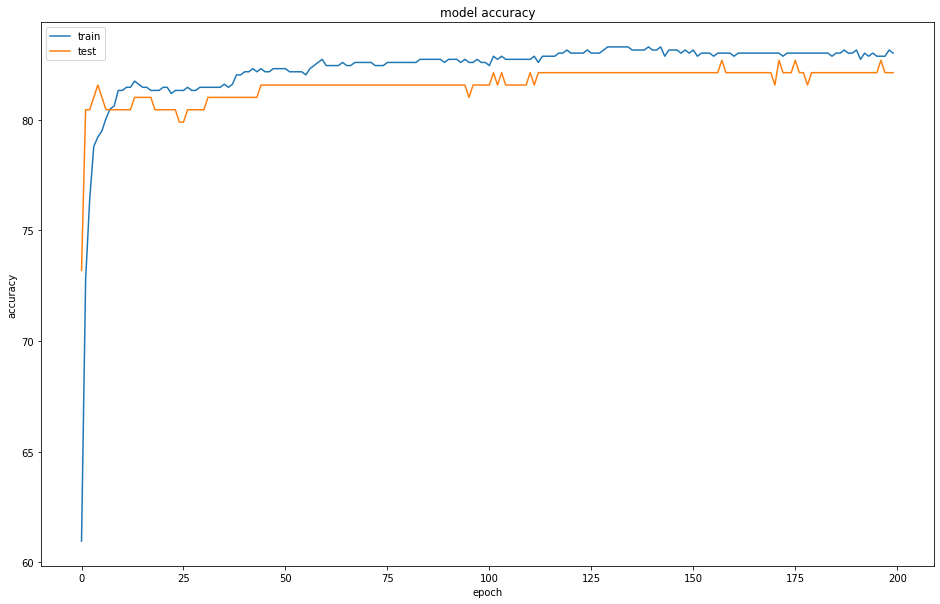

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_pt)
plt.plot(test_acc_pt)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

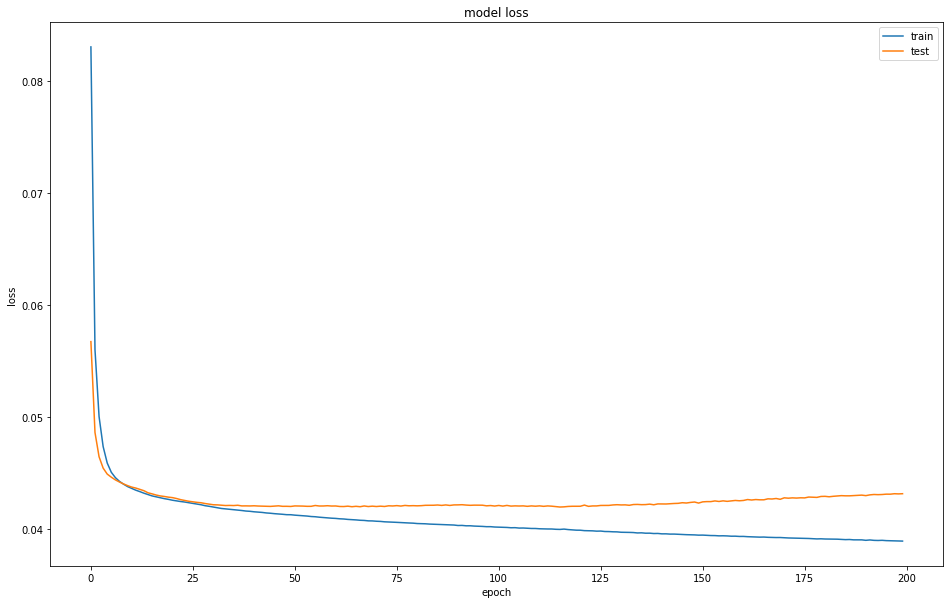

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(train_loss_pt)
plt.plot(test_loss_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper right')
plt.show()

### c) Inspect the first hidden layer after training

In [ ]:
model_pt[0].weight[0]

tensor([-0.4769, -0.9651,  0.2390,  0.2201,  0.4316,  0.8907, -0.4681],
       grad_fn=<SelectBackward>)

In [ ]:
model_pt[0].bias

Parameter containing:
tensor([ 1.6525e-01, -2.9096e-02,  9.0473e-02,  0.0000e+00,  8.0231e-02,
        -9.7597e-02, -1.4611e-03, -1.7222e-05,  1.2385e-01,  2.9950e-02,
         2.8596e-02, -8.7603e-02, -1.6842e-02,  3.1736e-03, -3.1290e-02,
        -5.4547e-03], requires_grad=True)

## 6. Evaluation

In [ ]:
y_pred = model_pt(x_test_pt) > 0.5

In [ ]:
accuracy_score(y_test_pt, y_pred)

0.8212290502793296